### DS 5110: Assignment 2
#### Eric Tria
#### emt4wf

[Git repository](https://github.com/erictria/dask_exercise)

In [1]:
"""
Assignment 2
Eric Tria
emt4wf
"""
import dask
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
import time
import json
import numpy as np

In [1]:
from IPython.display import Image

In [2]:
# TODO: fill out scheduler IP and port here when creating a Dask client object
# This is the private IP Address of my VM with the Dask Scheduler
# To run, make sure to change the IP Address with yours

client = Client('172.31.69.136:8786')
client = client.restart()
print(client)

<Client: 'tcp://172.31.69.136:8786' processes=8 threads=32, memory=61.31 GiB>


In [3]:
x = da.random.normal(size = 100_000_000, chunks = 1_000_000)

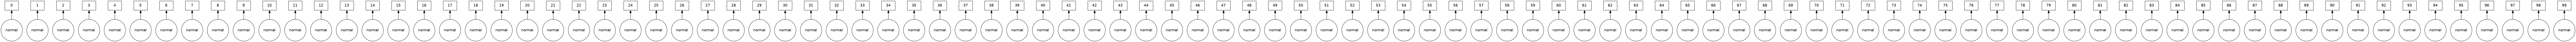

In [4]:
dask.visualize(x)

In [5]:
%%time

# Load the .CSV files into the Dask dataframes
# Loading the questions and question_tags files
questions = dd.read_csv('/home/ubuntu/questions.csv', sample=2**30, assume_missing=True)
question_tags = dd.read_csv('/home/ubuntu/question_tags.csv', sample=2**30, assume_missing=True)

CPU times: user 435 ms, sys: 3.13 s, total: 3.57 s
Wall time: 13.1 s


After initializing Dask, the Scheduler has 8 bars signifying the 2 workers for each of the 4 virtual machines where I ran `dask worker`. The dashboard looks like this:

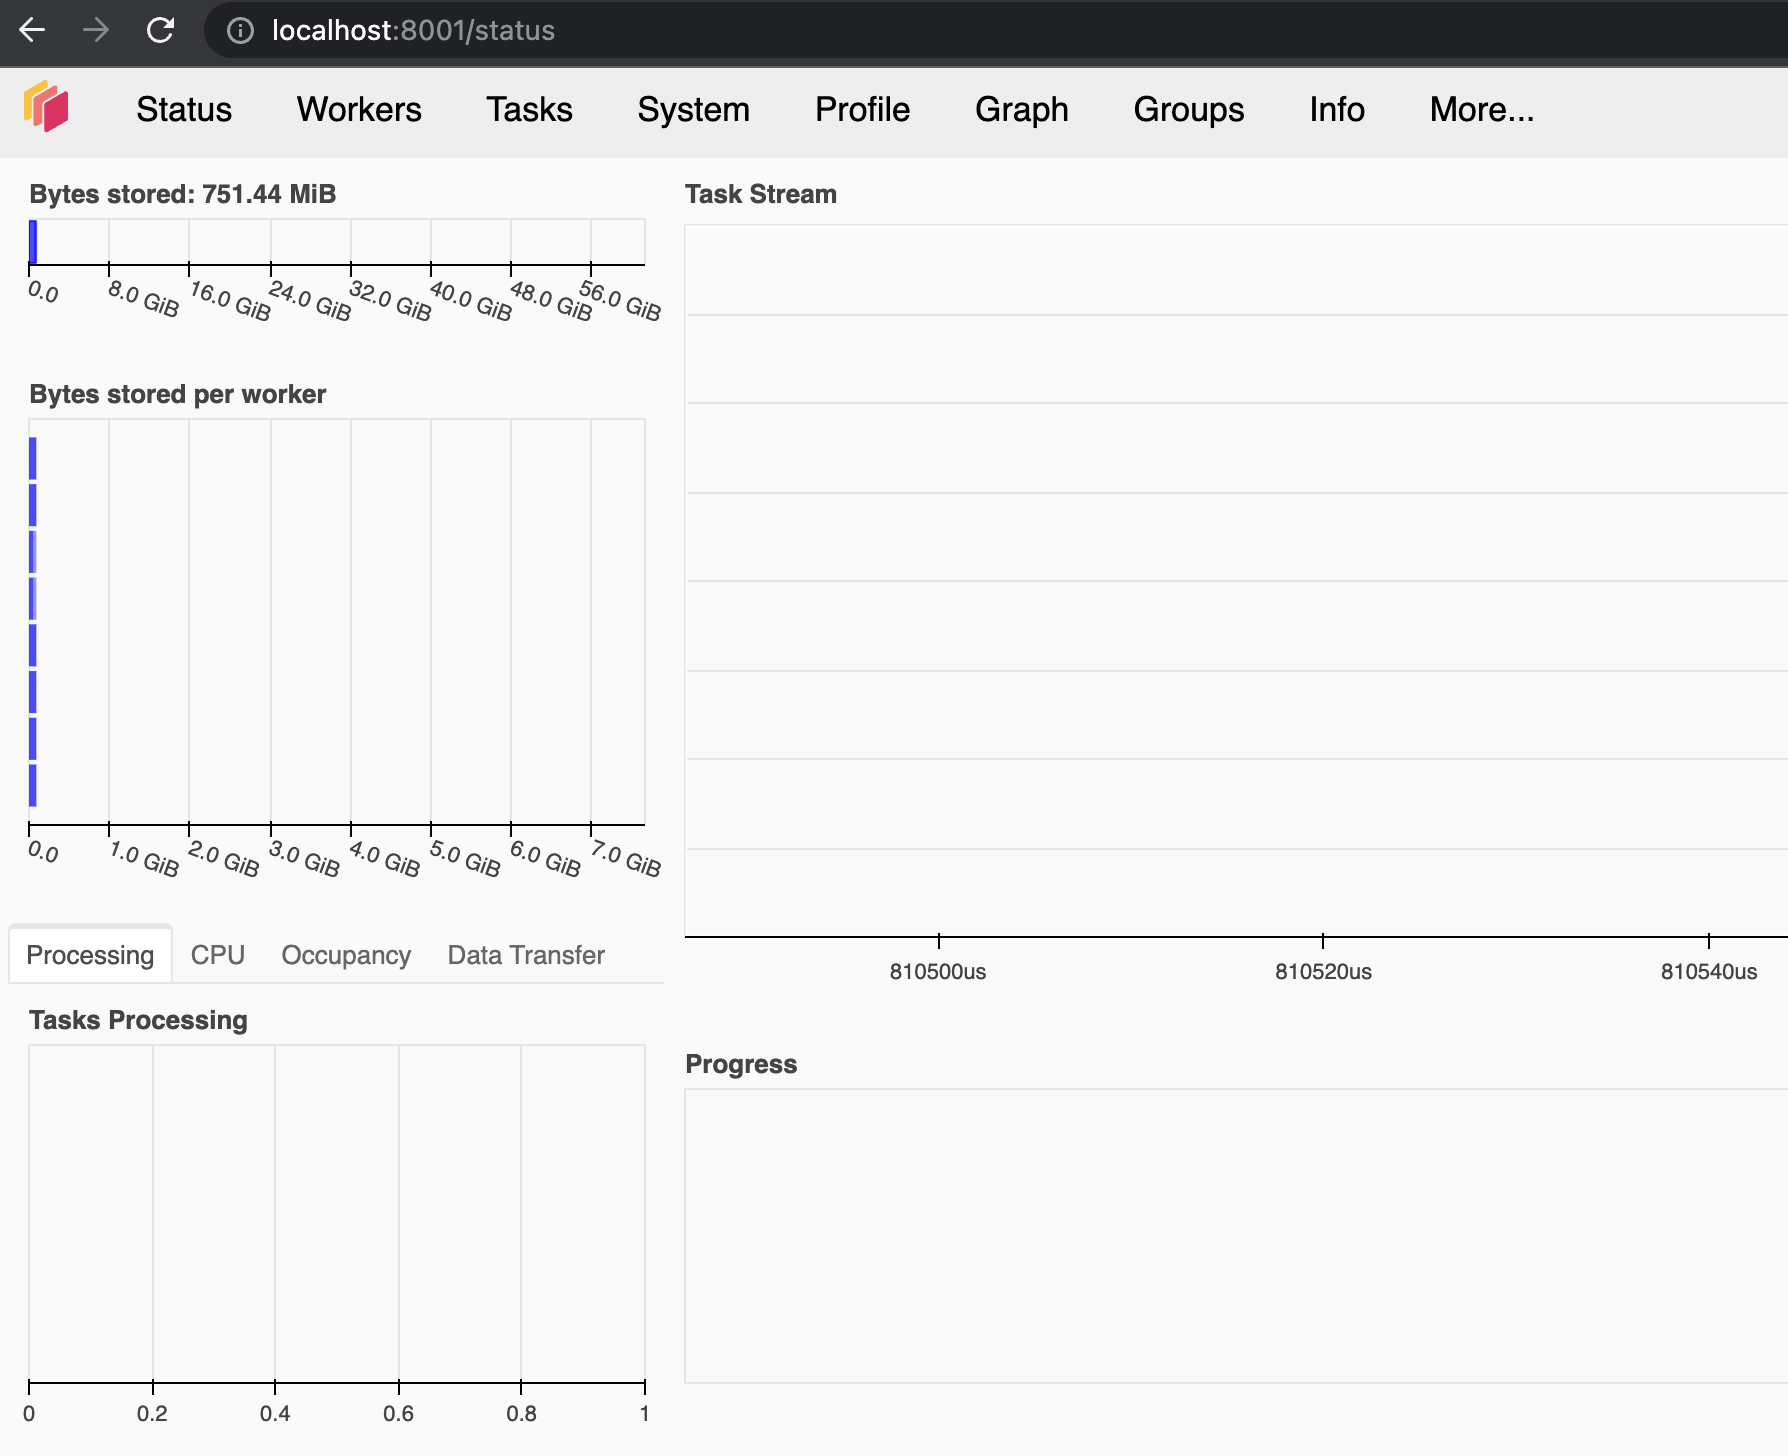

In [10]:
Image(filename='t0.png')

### Task 1
Get the percentage of missing values for all the columns in the *questions* table and the *question_tags* table.

In [6]:
%%time
# Task 1

# TODO: Start your implementation below this line
# Get the number of NA values per column (.isna()) and divides it by the total (.mean()) to get the percentage
questions_missing = questions.isna().mean().compute() * 100
question_tags_missing = question_tags.isna().mean().compute() * 100

print('Questions Missing')
print(questions_missing)

print('')
print('Questions Tags Missing')
print(question_tags_missing)

Questions Missing
Id               0.000000
CreationDate     0.000000
ClosedDate      89.973578
DeletionDate    76.962907
Score            0.000000
OwnerUserId     23.920885
AnswerCount     10.114036
dtype: float64

Questions Tags Missing
Id     0.000000
Tag    0.027501
dtype: float64
CPU times: user 162 ms, sys: 34.9 ms, total: 197 ms
Wall time: 15.7 s


For the questions table, the column with the highest percent of missing values is ClosedDate at 89.97%.

For the Question Tags table, it is mostly complete. The Tag column only has 0.027% missing data.

This is what the Dask dashboard looked like after running Task 1:

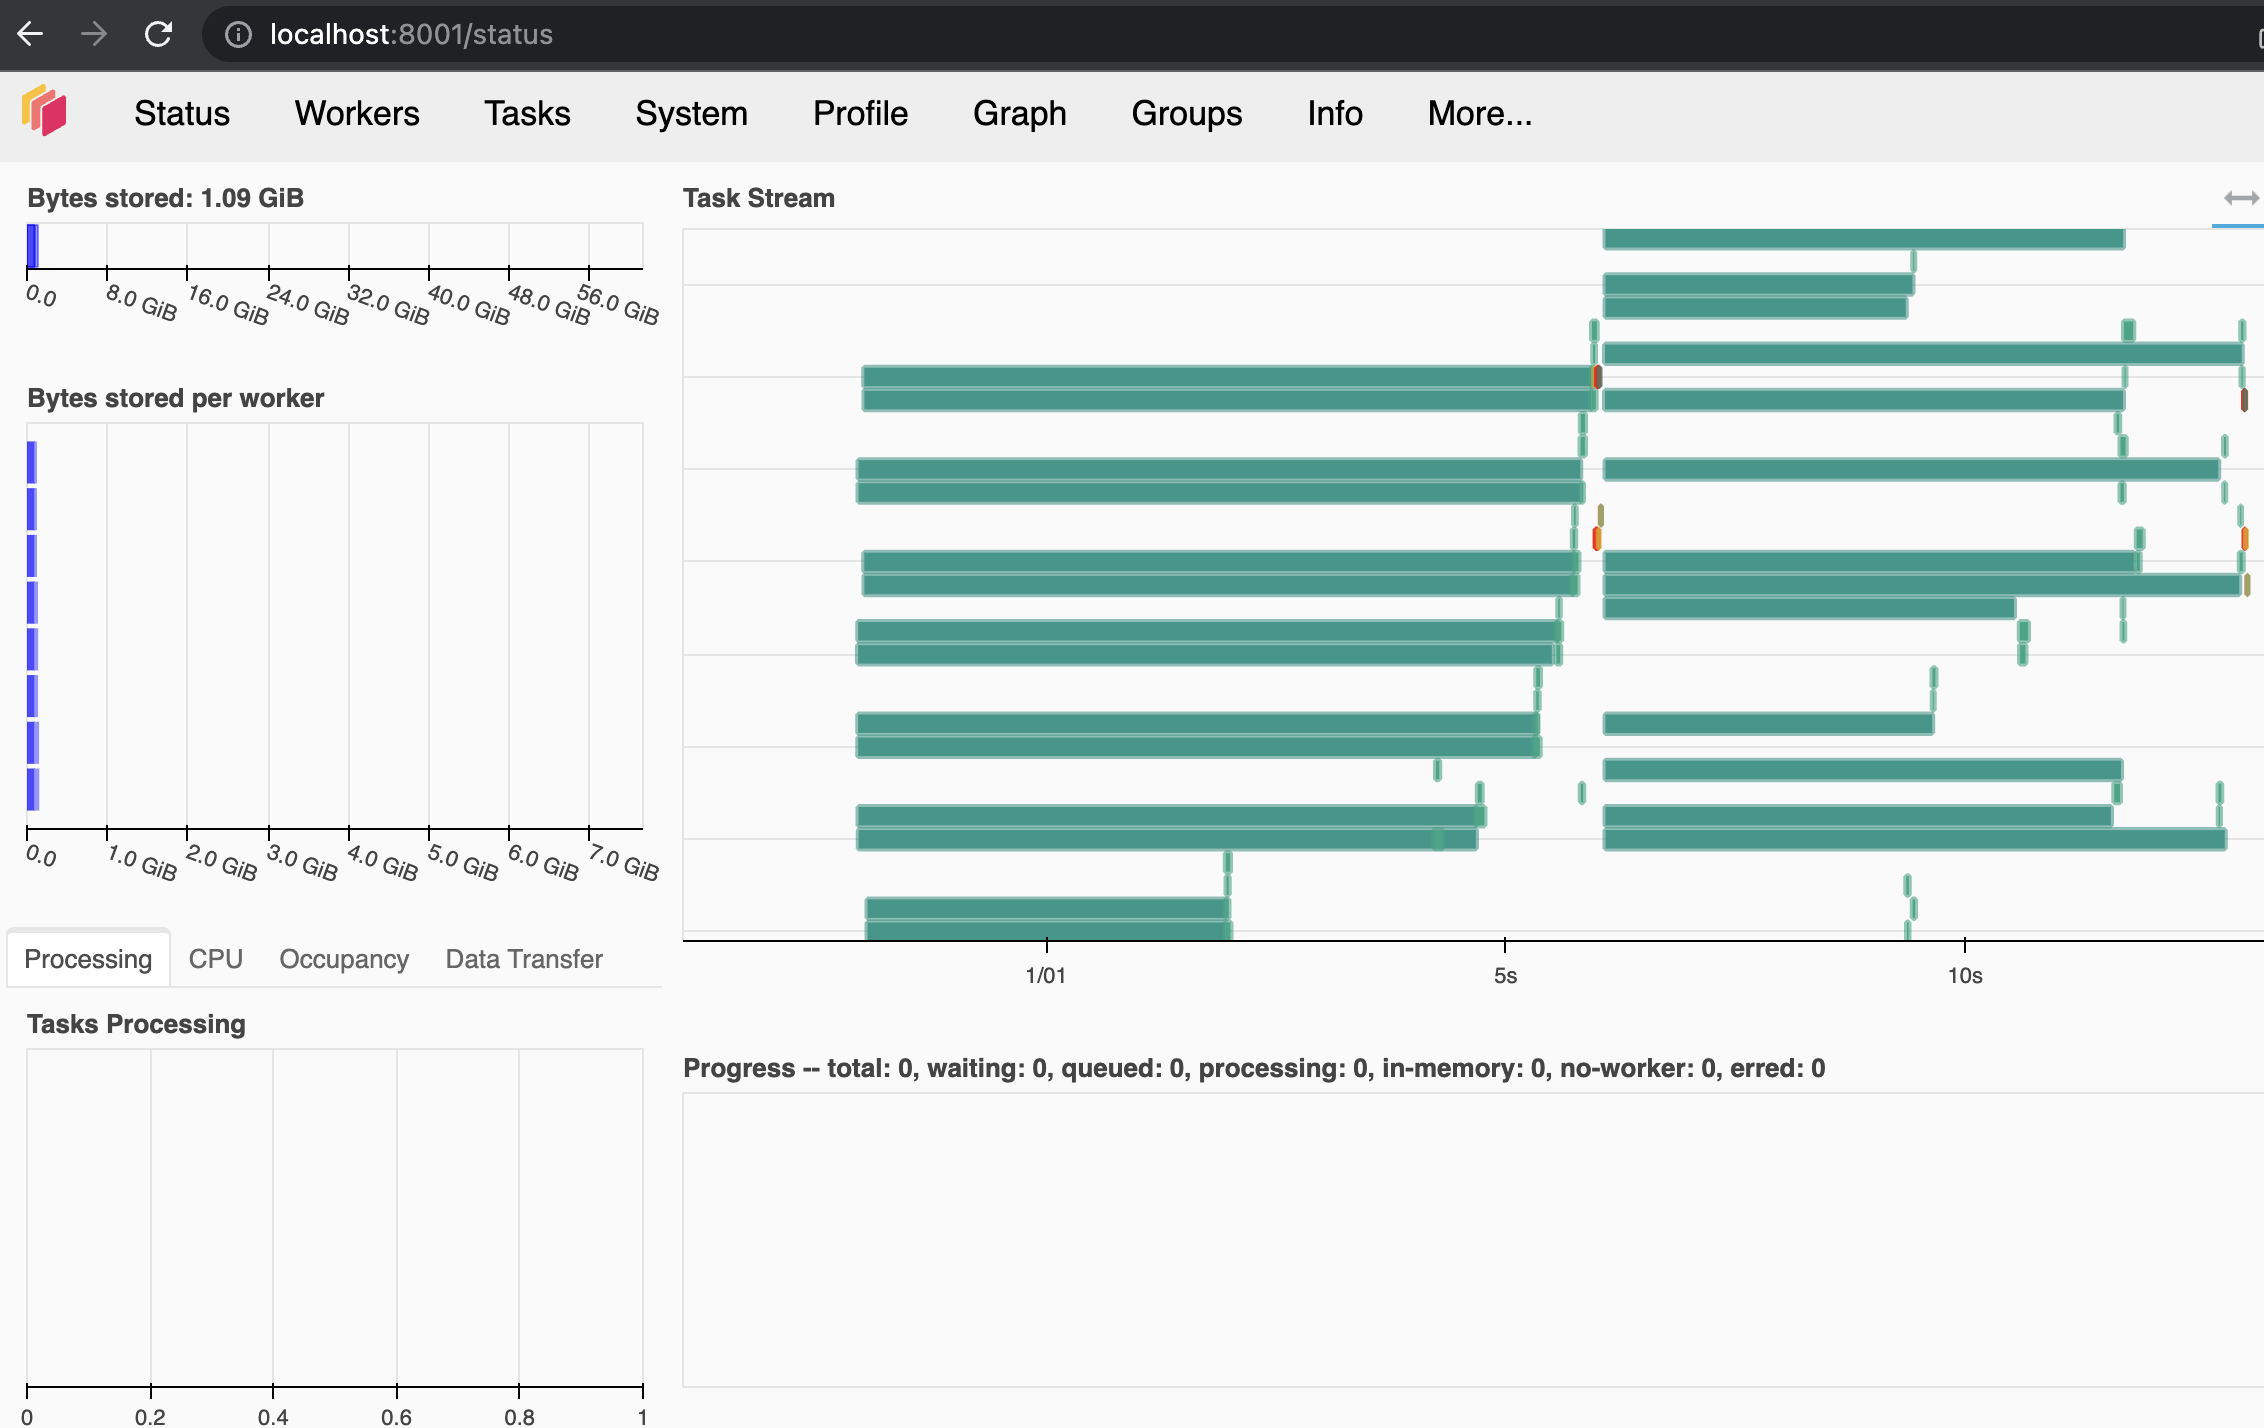

In [2]:
Image(filename='t1.png')

### Task 2
Get *mean, standard deviation, medium, min, and max* of the Score column in the *questions* table.

In [9]:
%%time
# Task 2

# TODO: Start your implementation below this line

# calculate various summary statistics for column 'A'
# Mean
mean_score = questions['Score'].mean().compute()

# Standard Deviation
std_score = questions['Score'].std().compute()

# Median
# Using this function because Dask doesn't implement an exact median in all cases as this is hard to do in parallel. 
# Docs recommended to use the `median_approximate` method instead, which uses an approximate algorithm
median_score_approx = questions['Score'].median_approximate().compute()
# Another way is to use the 0.5 quantile
median_score_quant = questions['Score'].quantile(0.5).compute()

# Min
min_score = questions['Score'].min().compute()

# Max
max_score = questions['Score'].max().compute()

# Print the results
print('Mean Score:', mean_score)
print('Standard deviation of Score:', std_score)
print('Median Score:', median_score_approx)
print('Median Score (Using 0.5 quantile):', median_score_quant)
print('Min Score:', min_score)
print('Max Score:', max_score)

Mean Score: 1.2041671665555287
Standard deviation of Score: 15.64573552737141
Median Score: 1.0
Median Score (Using 0.5 quantile): 1.0
Min Score: -154.0
Max Score: 16902.0
CPU times: user 115 ms, sys: 7.05 ms, total: 122 ms
Wall time: 12.2 s


Above are the various summary statistics for the Score column.

This is what the Dask dashboard looked like after running Task 2:

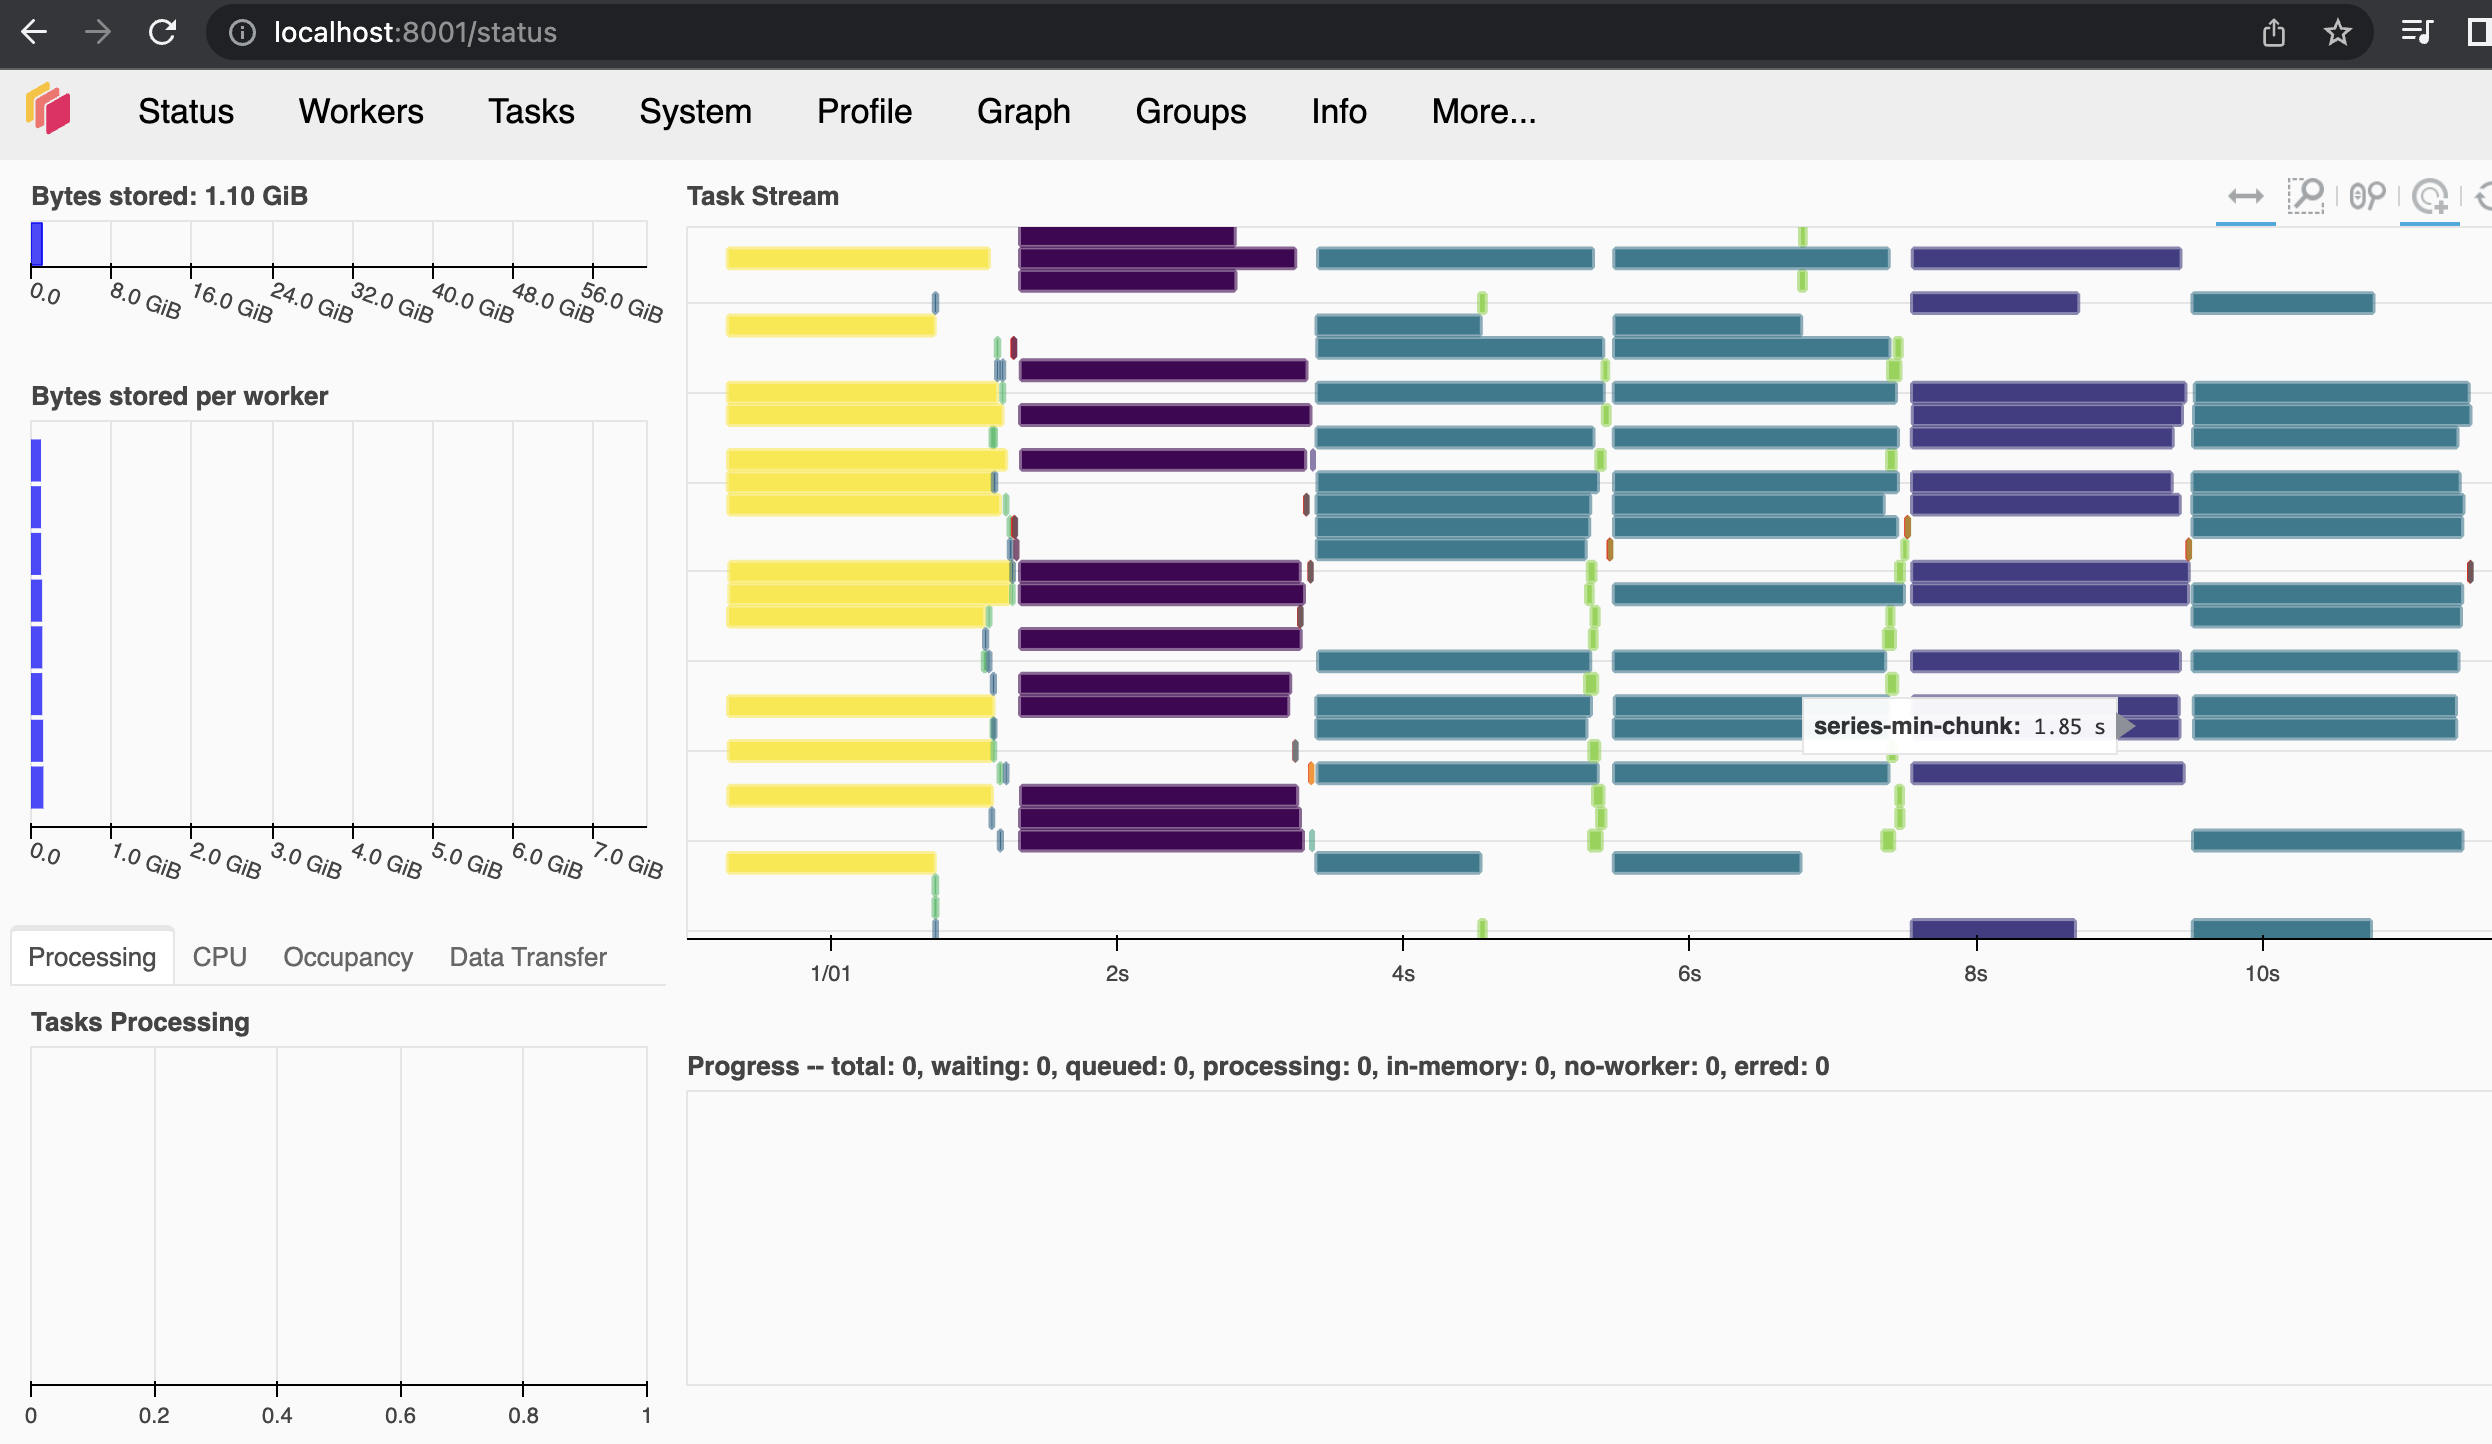

In [3]:
Image(filename='t2.png')

### Task 3
Get the top 5 tags that have the highest number of questions (hint: manipulate the *question_tags* table).

In [10]:
%%time
# Task 3

# TODO: Start your implementation below this line
# Group the question_tags table by Tag and count the values
# Sort the counts in descending order and get the top 5 rows to get the top 5 tags
tag_counts = question_tags.groupby('Tag').count().compute().sort_values(by = 'Id', ascending = False)
top_5_tags = tag_counts.head(5)
print('Top 5 tags:')
print(top_5_tags)

Top 5 tags:
                 Id
Tag                
javascript  1649631
java        1563820
php         1365600
c#          1321027
android     1288338
CPU times: user 44.6 ms, sys: 4.33 ms, total: 49 ms
Wall time: 6.71 s


The top 5 tags are `javascript, java, php, c#, and android`.

This is what the Dask dashboard looked like after running Task 3:

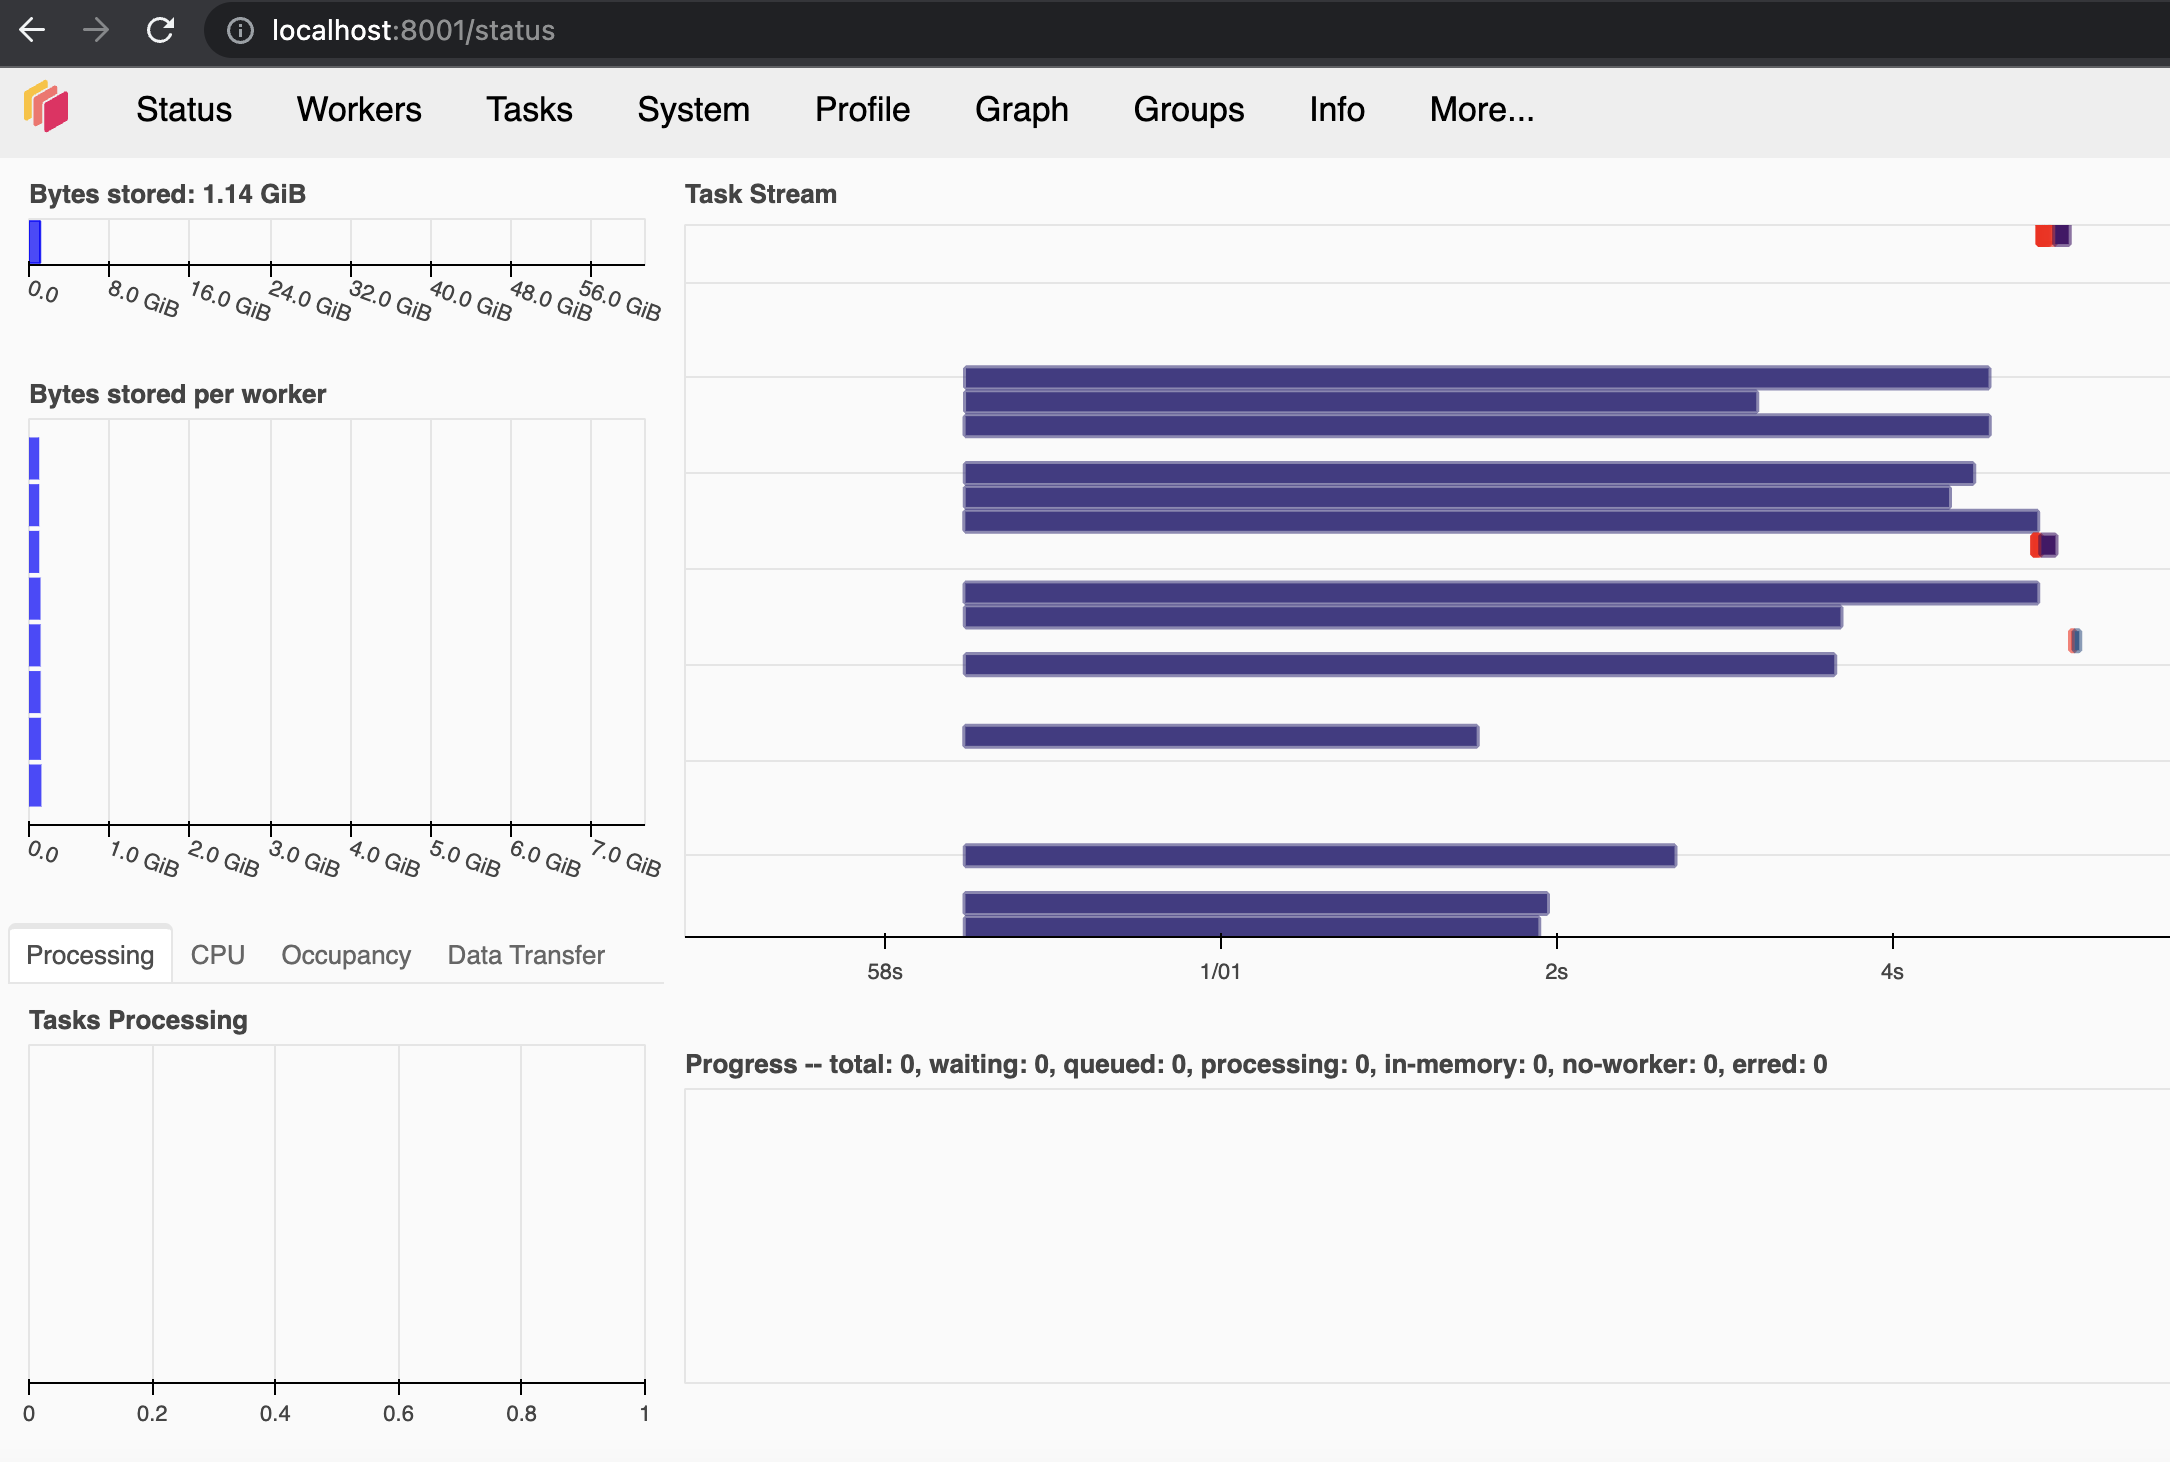

In [5]:
Image(filename='t3.png')

### Task 4
Check if there are any dangling references to the question Id field from the *questions* table to *question_tags* table. Return 1 if there are dangling references; return 0 otherwise.

In [13]:
len(questions['Id'].unique())

17203824

In [18]:
%%time
# Task 4

# TODO: Start your implementation below this line
# Check if there are dangling references from the questions table to the question_tags table

# Create boolean mask if the Id in questions is a dangling reference (not in question_tags)
# True if dangling; False if not
questions_mask = ~questions['Id'].isin(question_tags['Id'].compute().tolist())

# Convert boolean mask to 1 or 0
questions_dangling = questions.assign(dangling = questions_mask.astype(int))

# Summarize totals per group
questions_dangling_counts = questions_dangling.groupby('dangling')['Id'].count()
print(questions_dangling_counts.compute())

dangling
0    17203824
Name: Id, dtype: int64
CPU times: user 24.7 s, sys: 3.18 s, total: 27.9 s
Wall time: 54.2 s


Out of 17203824 unique questions in the questions table, there are no dangling references to the question_tags table.

To check the other way around:

In [16]:
len(question_tags['Id'].unique())

17203824

In [17]:
%%time
# Task 4

# TODO: Start your implementation below this line
# Check other way around
# Check if there are dangling references from the question_tags table to the questions table

# Create boolean mask if the Id in question_tags is a dangling reference (not in questions)
# True if dangling; False if not
question_tags_mask = ~question_tags['Id'].isin(questions['Id'].compute().tolist())

# Convert boolean mask to 1 or 0
question_tags_dangling = question_tags.assign(dangling = question_tags_mask.astype(int))

# Summarize totals per group
question_tags_dangling_counts = question_tags_dangling.groupby('dangling')['Id'].count()
print(question_tags_dangling_counts.compute())

dangling
0    50576842
Name: Id, dtype: int64
CPU times: user 17.2 s, sys: 1.47 s, total: 18.7 s
Wall time: 46.4 s


Out of 17203824 unique questions (50576842 rows total) in the question_tags table, there are no dangling references to the questions table.

There are **no dangling references** from the *questions* table to the *question_tags* table.

This is what the Dask dashboard looked like after running Task 4:

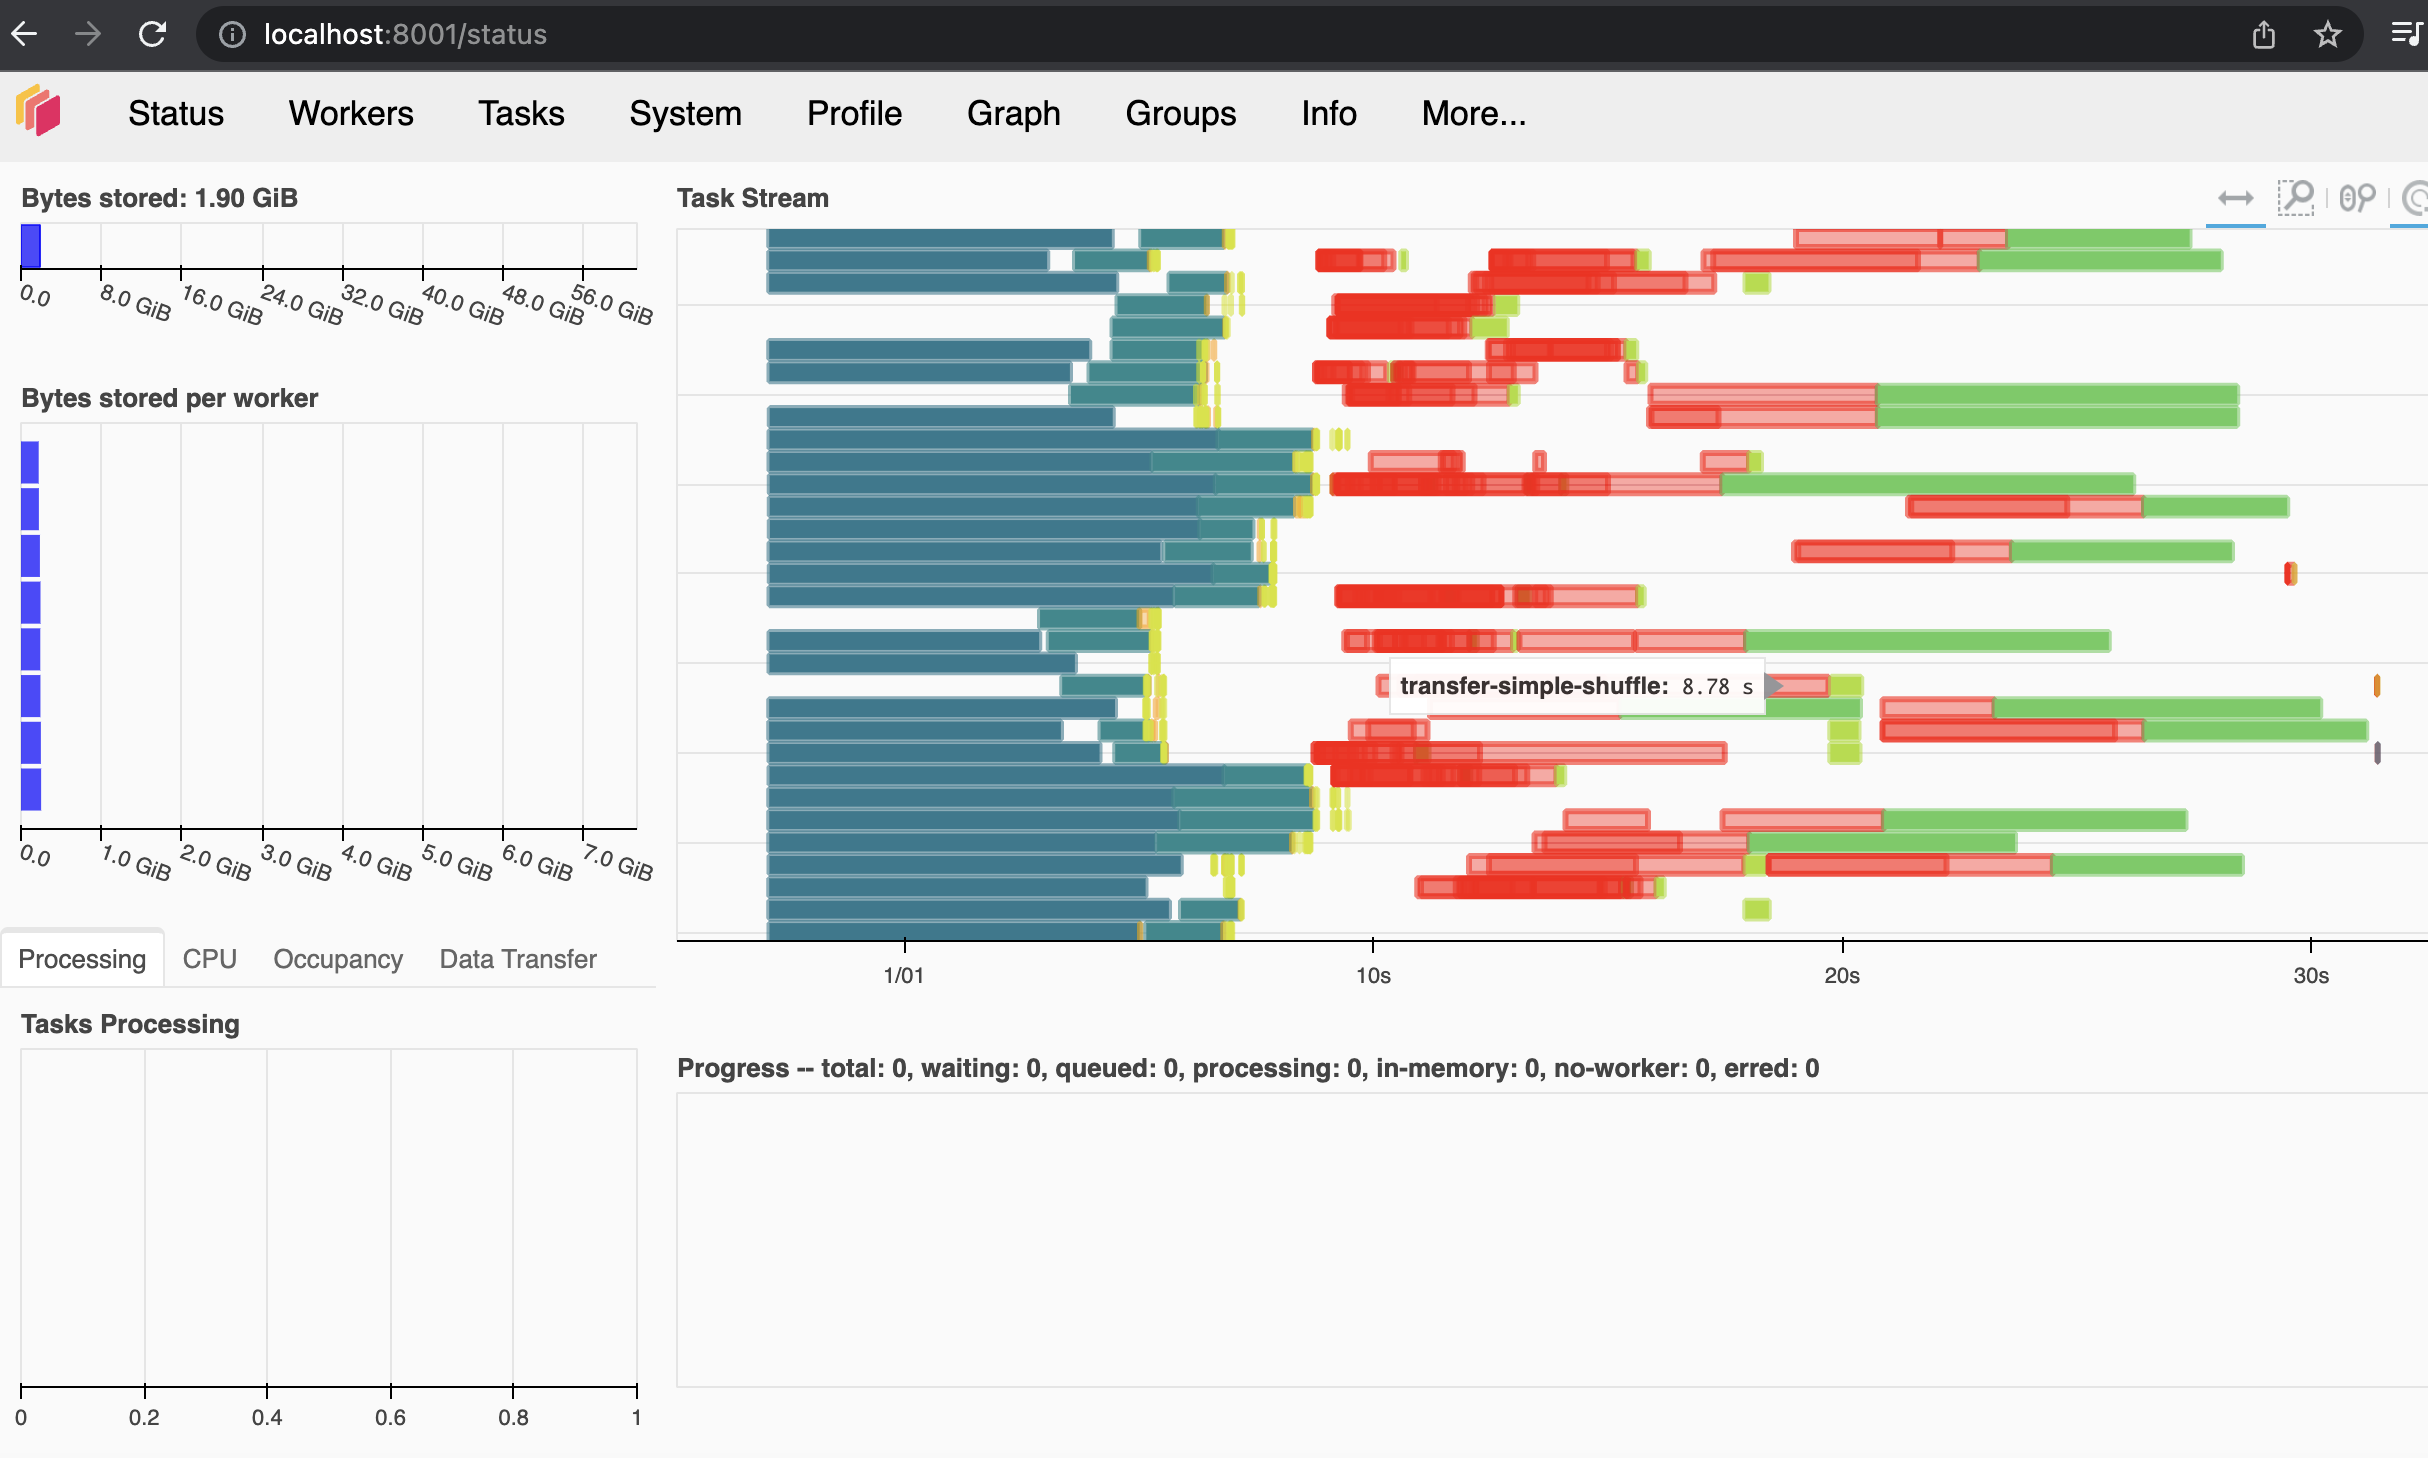

In [6]:
Image(filename='t4.png')

### Task 5
Create a new owner user table based on the questions table grouped by the OwnerUserId field. Refer to this link for Dask’s groupby operator. The new table should have the following fields: (1) OwnerUserId: the field that the table is grouped by; (2) AverageScore: aggregated by getting the average score value of the owner user; (3) NumQuestions: aggregated by getting count value of the Id field of corresponding owner users; (4) NumAnswers: aggregated by getting the sum value of the AnswerCount field of corresponding owner users.

Output the top 5 owner users who asked the most number of questions.

In [18]:
%%time
# Task 5

# TODO: Start your implementation below this line

# Group the questions by OwnerUserId and calculate the aggregated values
# Apply mean to Score, count to Id, and sum to AnswerCount
owner_user_df = questions.groupby('OwnerUserId').agg({
    'Score': 'mean',
    'Id': 'count',
    'AnswerCount': 'sum'
})

# Rename the columns to match the column names in the given schema
owner_user_df = owner_user_df.rename(columns={
    'Score': 'AverageScore',
    'Id': 'NumQuestions',
    'AnswerCount': 'NumAnswers'
})

# Reset the index to turn the OwnerUserId column into a regular column
# OwnerUserId turned into an Index because of the groupby operation earlier
owner_user_df = owner_user_df.reset_index()

# Display the resulting owner user table
# Getting the top 5 users who answered the most questions
print('Top 5 Owner Users who answered the most questions:')
print(owner_user_df.sort_values(by = 'NumAnswers', ascending = False).head(5))


Top 5 Owner Users who answered the most questions:
       OwnerUserId  AverageScore  NumQuestions  NumAnswers
1972        4653.0      6.883095          1822      5696.0
9195       39677.0      6.607613          2128      5176.0
9347       34537.0      5.213690          1680      4525.0
41352     179736.0      7.344987          1516      3982.0
20361      84201.0      6.734388          1201      3787.0
CPU times: user 42.2 ms, sys: 5.06 ms, total: 47.3 ms
Wall time: 7.36 s


Above are the top 5 owner users who answered the most questions.

This is what the Dask dashboard looked like after running Task 5:

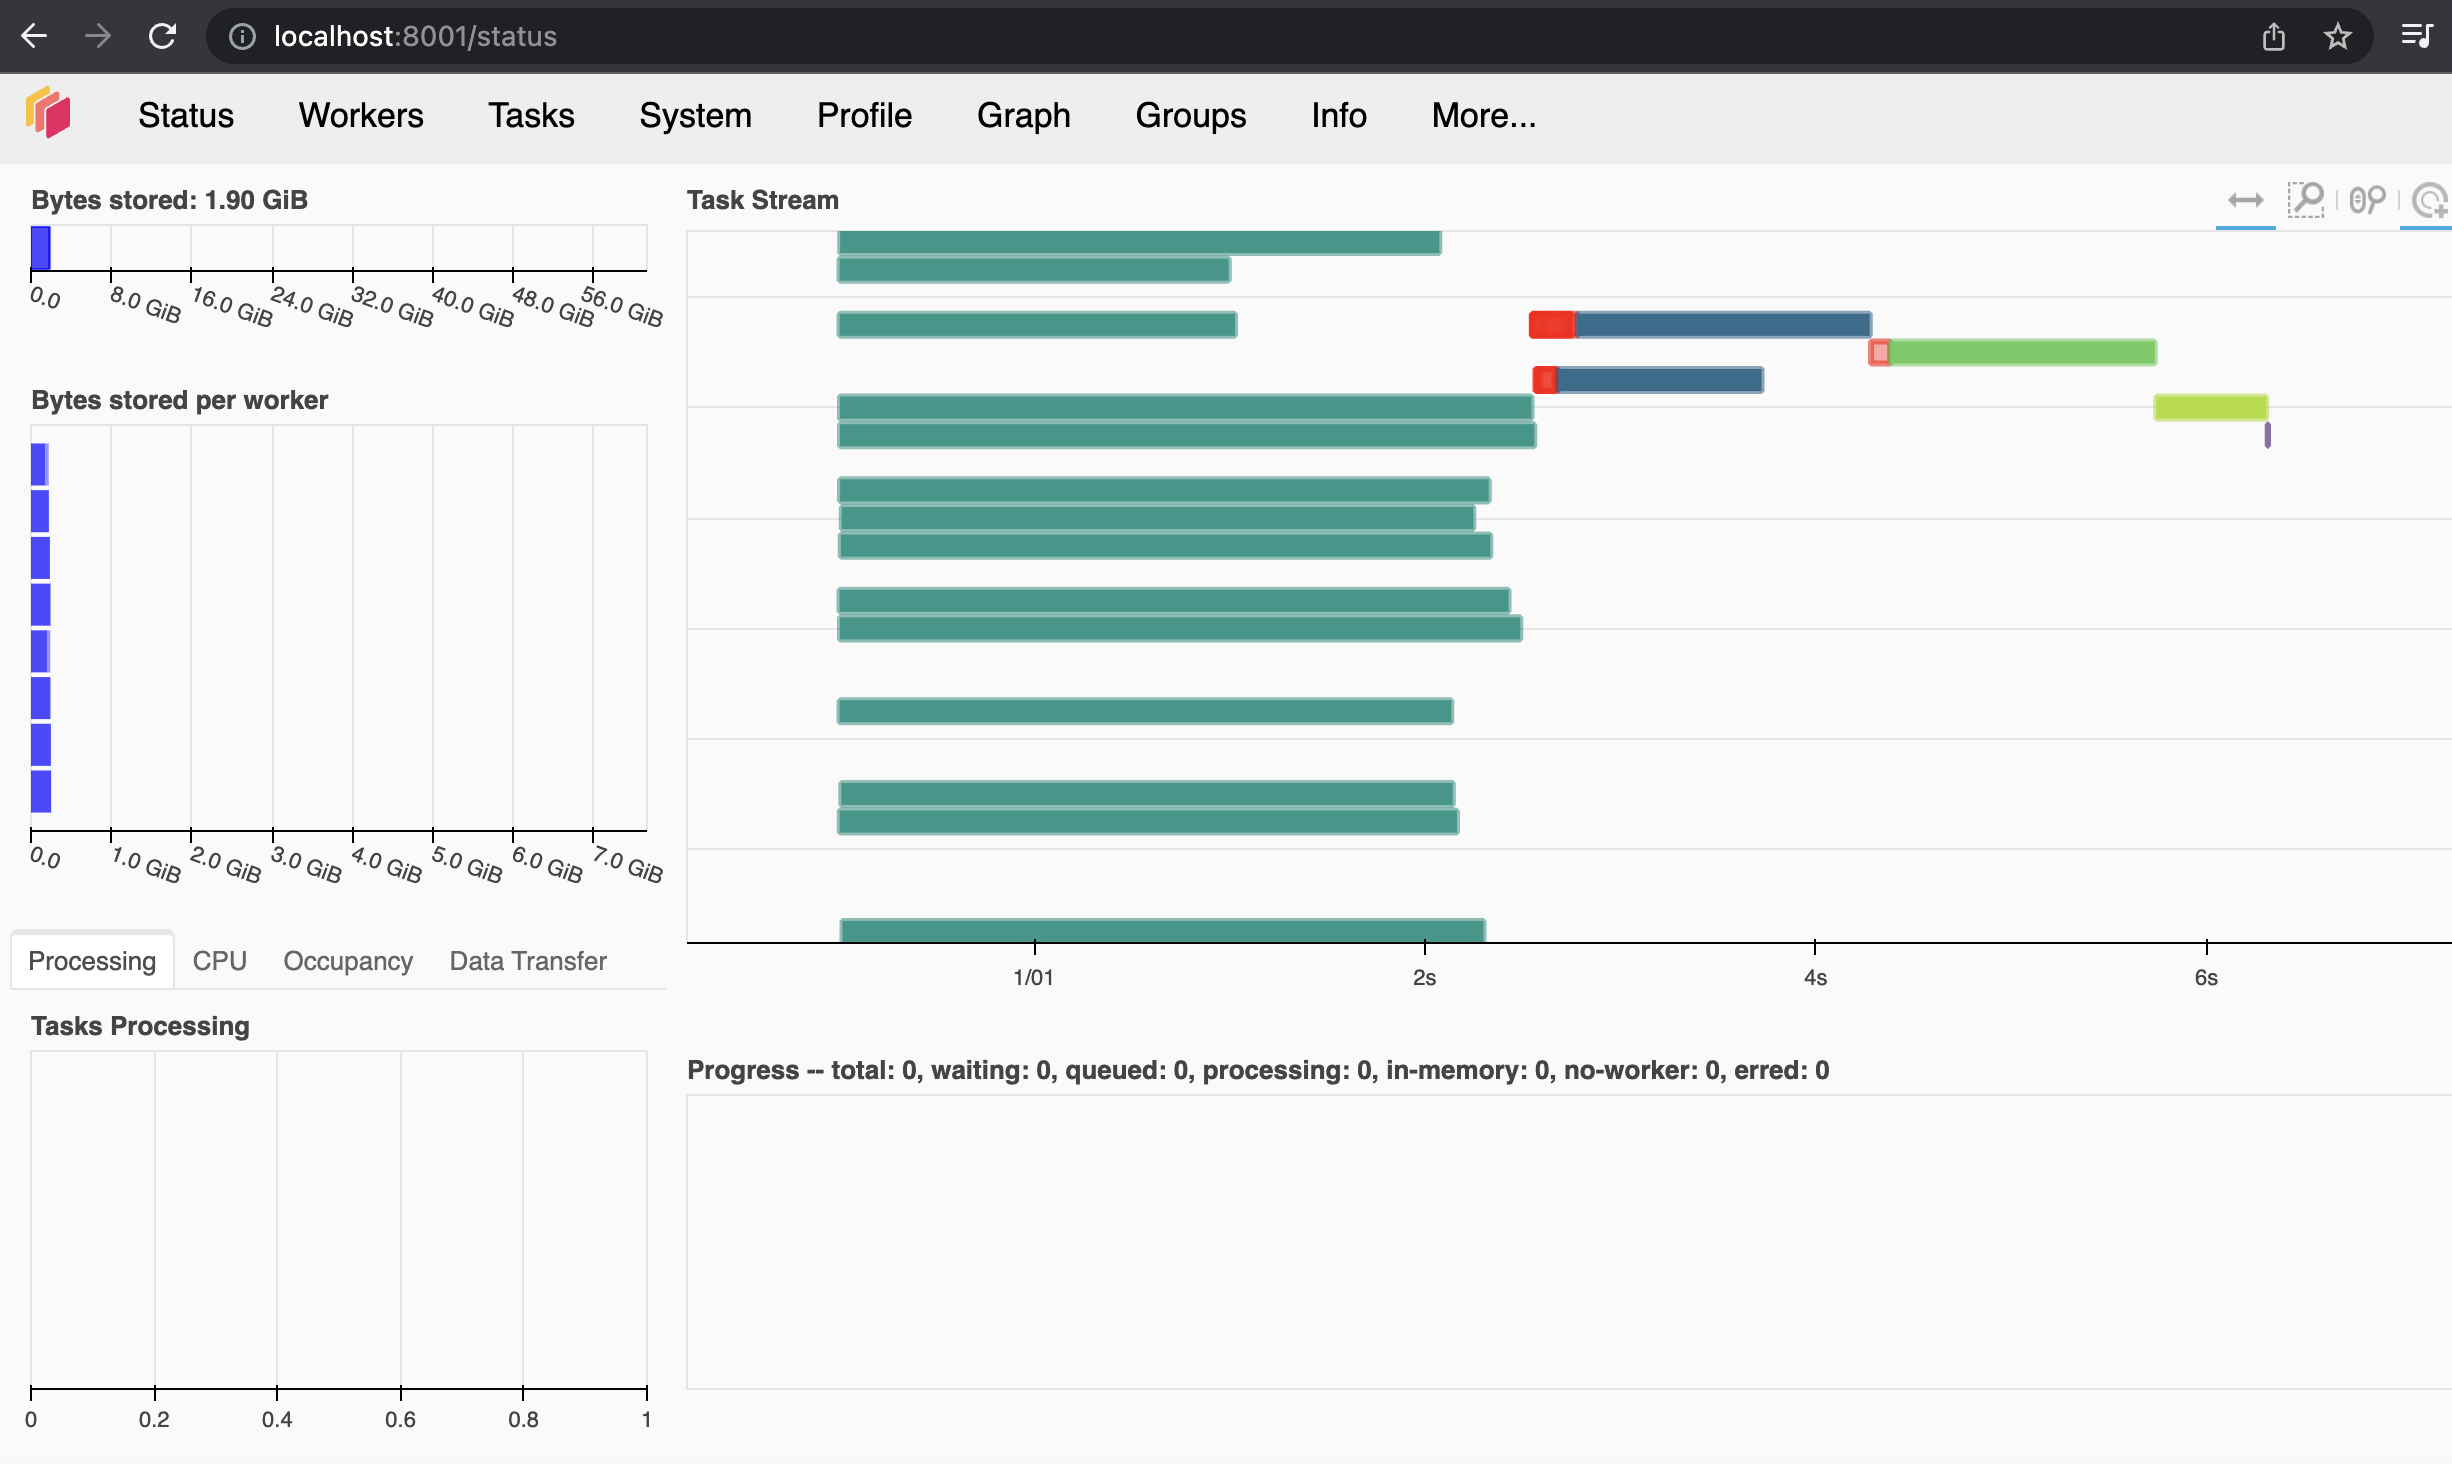

In [7]:
Image(filename='t5.png')

### Task 6
Create a new table by merging the questions table and the question_tags table using Id as the index. Then group the new table by Tag with the following aggregated fields: (1) Tag: the field that the table is grouped by; (2) AverageScore: aggregated by getting the average score value of the corresponding tags; (3) NumAnswers: aggregated by getting the sum value of the AnswerCount field of corresponding tags; (4) NumQuestions: aggregated by getting the count value of the Id field of corresponding tags; and (5) NumOwners: aggregated by getting the count value of the OwnerUserId field of corresponding tags.

This task should output the top 5 tags with the highest number of questions and the top 5 tags with the highest number of answers received.

In [19]:
%%time
# Task 6

# TODO: Start your implementation below this line

# Merge the two tables on the Id column
merged_df = questions.merge(question_tags, on='Id')

# Group the merged table by Tag and calculate the aggregated values
# Apply mean to Score, sum to AnswerCount, and count to Id and OwnerUserId
tag_df = merged_df.groupby('Tag').agg({
    'Score': 'mean',
    'AnswerCount': 'sum',
    'Id': 'count',
    'OwnerUserId': 'count'
})

# Rename the columns to match the required column names in the schema
tag_df = tag_df.rename(columns={
    'Score': 'AverageScore',
    'AnswerCount': 'NumAnswers',
    'Id': 'NumQuestions',
    'OwnerUserId': 'NumOwners'
})

# Reset the index to turn the Tag column into a regular column
# Tag was turned into an index because of the groupby operation
tag_df = tag_df.reset_index()

# Getting the top 5 tags with the highest number of questions
print('Top 5 tags with the highest number of questions:')
print(tag_df.sort_values(by = 'NumQuestions', ascending = False).head(5))
print('')

# Getting the top 5 tags with the highest number of answers
print('Top 5 tags with the highest number of answers:')
print(tag_df.sort_values(by = 'NumAnswers', ascending = False).head(5))


Top 5 tags with the highest number of questions:
            Tag  AverageScore  NumAnswers  NumQuestions  NumOwners
57   javascript      1.134249   2252471.0       1649631    1296260
116        java      1.056542   2194354.0       1563820    1189238
0           php      0.375525   1855546.0       1365600    1017270
15           c#      1.340325   1937822.0       1321027    1039994
362     android      1.004450   1420669.0       1288338     936349

Top 5 tags with the highest number of answers:
            Tag  AverageScore  NumAnswers  NumQuestions  NumOwners
57   javascript      1.134249   2252471.0       1649631    1296260
116        java      1.056542   2194354.0       1563820    1189238
15           c#      1.340325   1937822.0       1321027    1039994
0           php      0.375525   1855546.0       1365600    1017270
110      jquery      0.881797   1462029.0       1011324     801493
CPU times: user 128 ms, sys: 6.77 ms, total: 135 ms
Wall time: 1min 6s


Above are the top 5 tags with the highest number of questions and the top 5 tags with the highest number of answers.

This is what the Dask dashboard looked like after running Task 6:

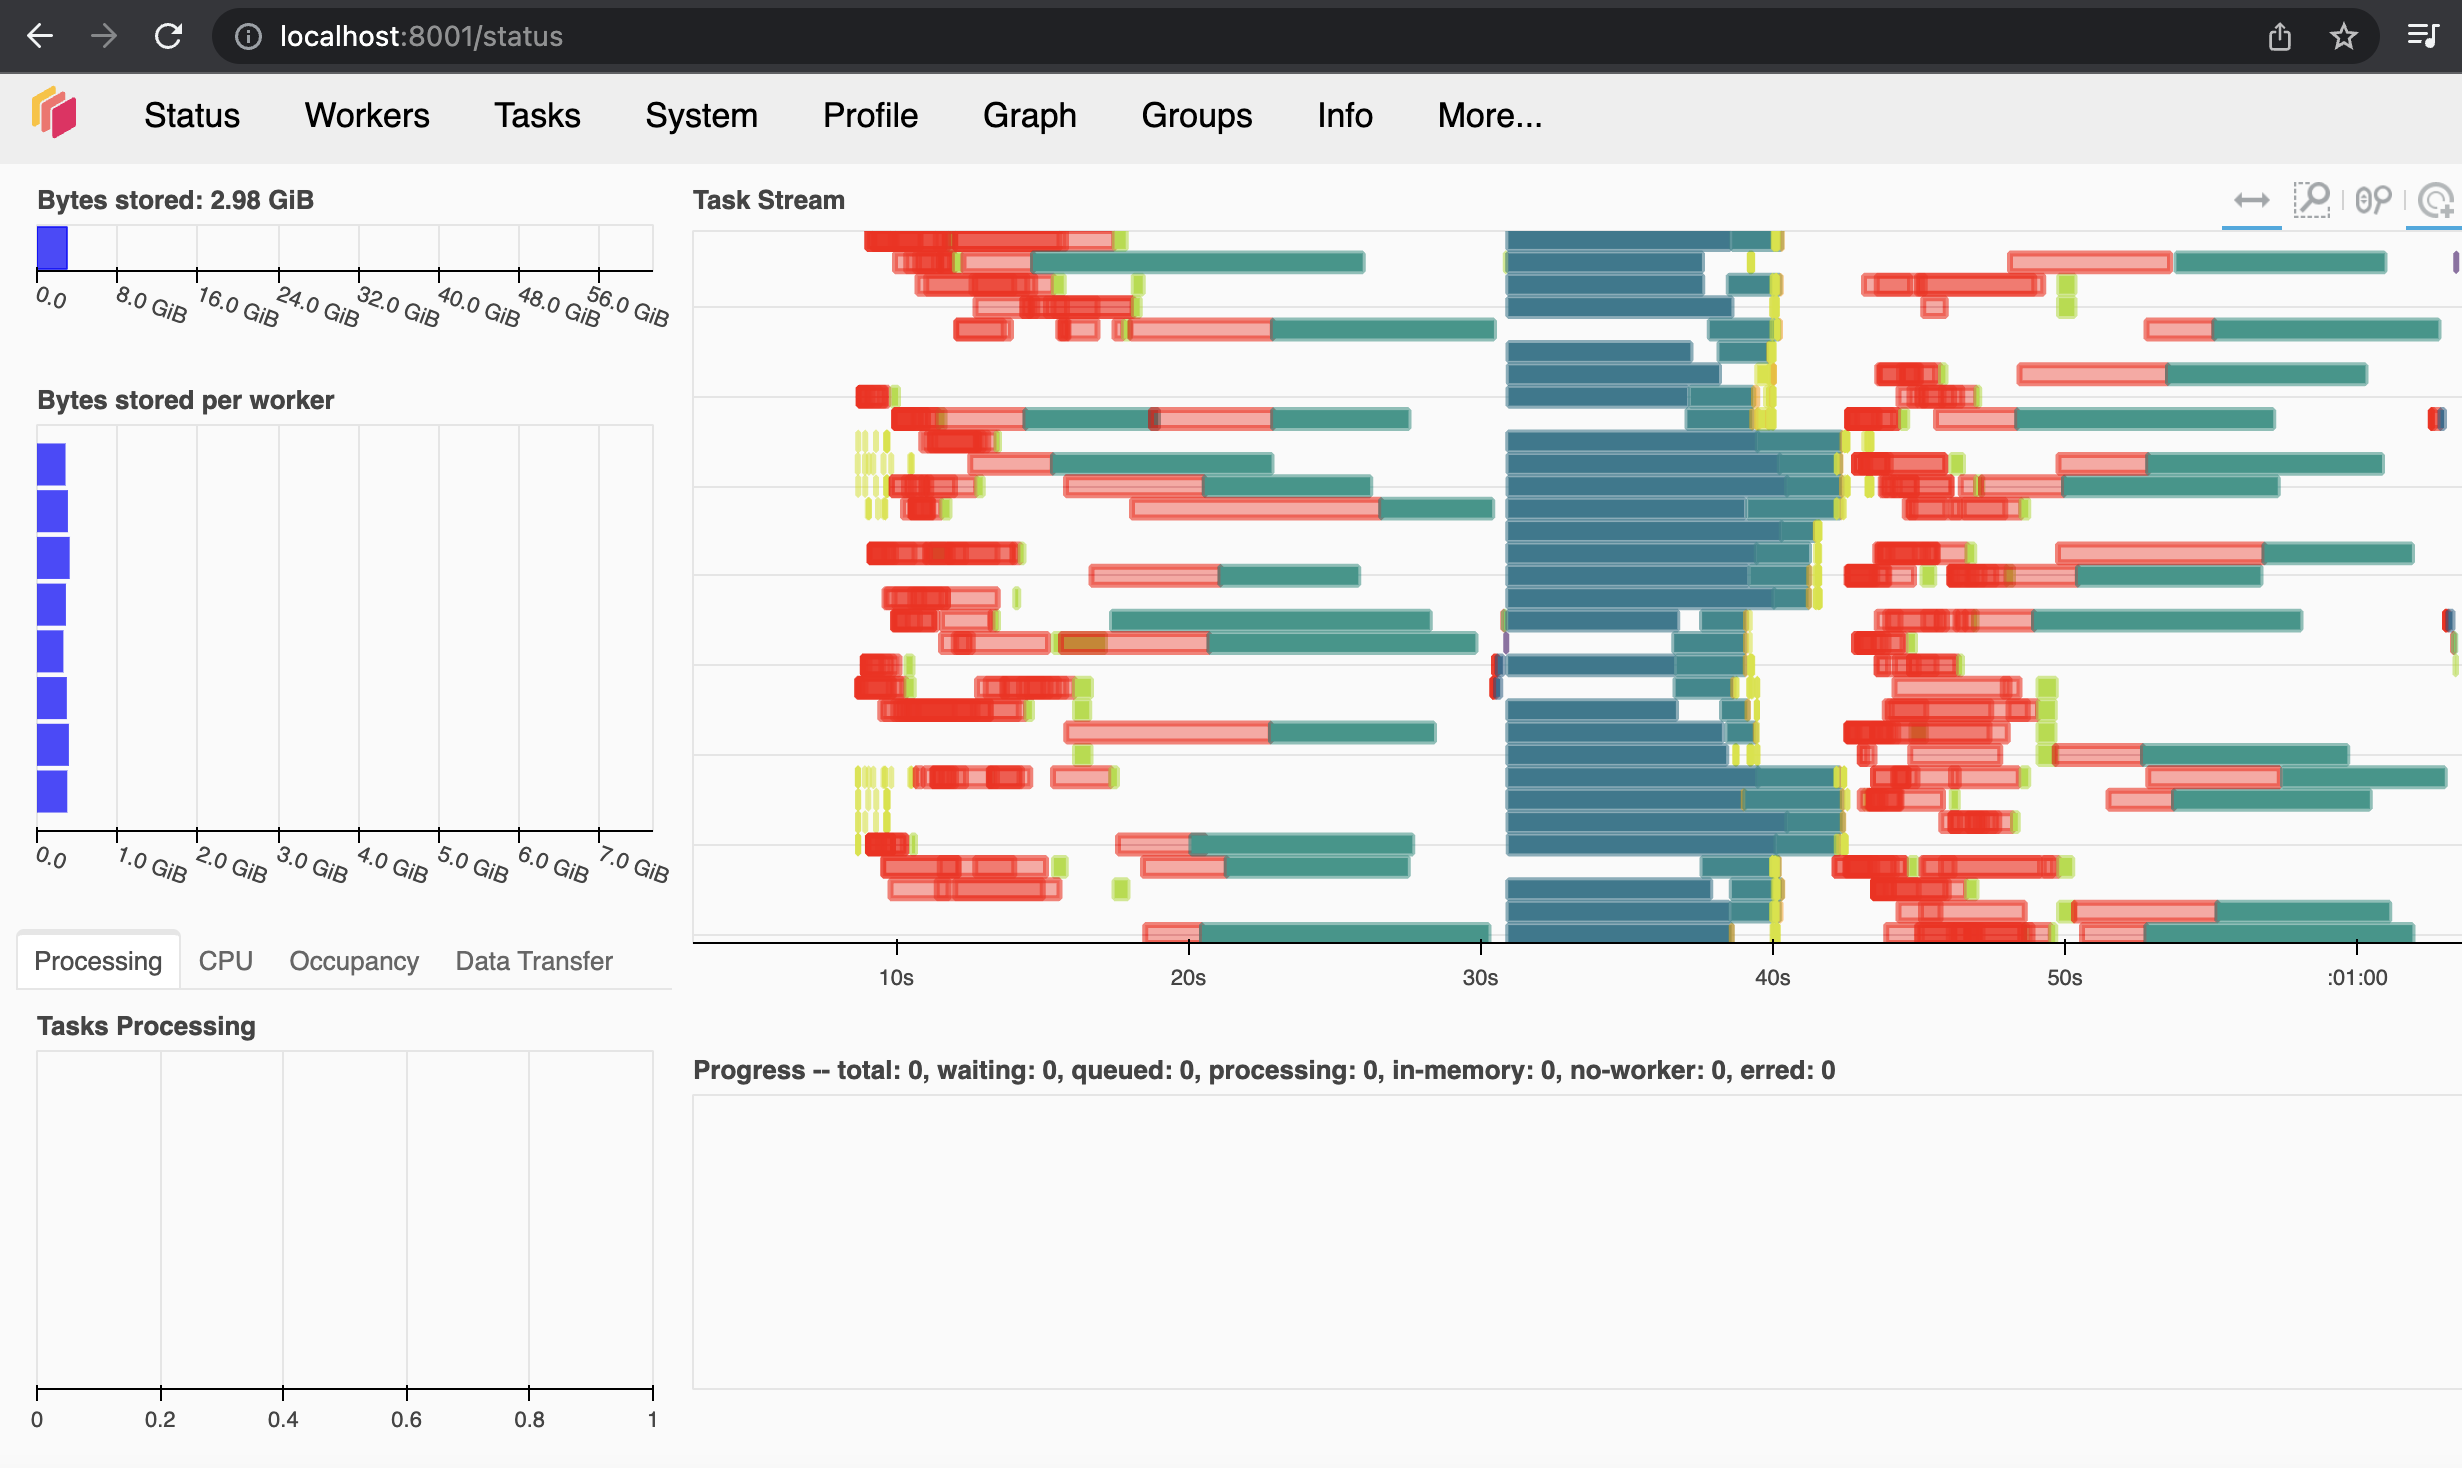

In [9]:
Image(filename='t6.png')